### Generating Relevant Keywords

As an SEO professional, targeting relevant keywords can be daunting task. In addition to hitting your business goals (revenue, conversions, clicks, etc.), you also need structures and patterns that can be used to standardize the analytical process. 

We are tasked with creating a prototype set of keywords using historic Search Console Data. While there are numerous text mining techniques and approaches, I will focus on one topic for this analysis: extracting entities. First, we'll extract a few hundred keywords and then we will select few keywords that we believe are the most relevant.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from collections import defaultdict
%matplotlib inline
sns.set_style("whitegrid")

### Importing the dataset and cleaning the data

In [2]:
# Read in the data
data_df = pd.read_csv('test_file.csv',encoding='UTF-8')

# Display the data
display(data_df.head())
print(data_df.shape)

,Document Text,Views,Clicks
0,Classic Italy,132,25
1,Grand Australia &amp; New Zealand 2018,567,395
2,The Five Stans of the Silk Road,191,129
3,Journey Through the Holy Land - Faith-Based Tr...,636,533
4,"Portugal, Spain, France and UK Adventure Tour",412,148


(9966, 3)


In [3]:
# Changing column names
data_df.rename(columns={"Document Text": "document_text", "Views": "impression", "Clicks":"clicks"}, inplace=True)
display(data_df.tail())

,document_text,impression,clicks
9961,Beautiful Cuba - Independent Journey,744,272
9962,A Touch of Cuba,657,161
9963,Sea Kayaking Tortuguero,666,459
9964,Cuba Music &amp; Dance,813,500
9965,Rose Red City,500,440


### Cleaning dataset

We are going to define a function that takes in a string as an input and outputs clean string value

In [4]:
from nltk.corpus import stopwords
stopwords.words('english')
stop_words = stopwords.words('english')

In [5]:
def clean_text(text):
    cl_text= text.replace('amp;','')
    cl_text = re.sub(r'\W',',',cl_text)
    cl_text = re.sub(r',{1}',' ',cl_text)
    cl_text = re.sub(r'\d','',cl_text)
    cl_text = re.sub(r'\s{2:}','',cl_text)
    clean_word_list = [word for word in cl_text.split() if word not in stop_words]
    cl_text = ' '.join(clean_word_list)
    return cl_text

In [6]:
data_df['clean_text']=data_df['document_text'].apply(clean_text)
data_df.head()

,document_text,impression,clicks,clean_text
0,Classic Italy,132,25,Classic Italy
1,Grand Australia &amp; New Zealand 2018,567,395,Grand Australia New Zealand
2,The Five Stans of the Silk Road,191,129,The Five Stans Silk Road
3,Journey Through the Holy Land - Faith-Based Tr...,636,533,Journey Through Holy Land Faith Based Travel
4,"Portugal, Spain, France and UK Adventure Tour",412,148,Portugal Spain France UK Adventure Tour


### Text feature extraction

We are going define a function for named entity recognizer SpaCy, to identify locations in the raw text. The objective is to get list of loctions associated with each search query.

In [7]:
nlp_1 = spacy.load("en_core_web_sm")
nlp_2 = spacy.load("en_core_web_md")
nlp_3 = spacy.load("en_core_web_lg")

In [8]:
def destination_matcher(string):
    with nlp_1.disable_pipes('tagger', 'parser'):
        doc_1 = nlp_1(string)
        hk = [enti_1.text for enti_1 in doc_1.ents if enti_1.label_ in ["GPE","LOC"]]
    with nlp_2.disable_pipes('tagger', 'parser'):
        doc_2 = nlp_2(string)
        jk = [enti_2.text for enti_2 in doc_2.ents if enti_2.label_ in ["GPE","LOC"]]
    with nlp_3.disable_pipes('tagger', 'parser'):
        doc_3 = nlp_3(string)
        ck = [enti_3.text for enti_3 in doc_3.ents if enti_3.label_ in ["GPE","LOC"]]
    dk = set(hk+jk+ck)
    return ','.join(dk)

In [9]:
def matcher_func_adj(string):
    with nlp_1.disable_pipes('parser','ner'):
        doc_1 = nlp_1(string)
        hk = [word_1.text for word_1 in doc_1 if word_1.pos_=='ADJ']
    with nlp_2.disable_pipes('parser','ner'):
        doc_2 = nlp_2(string)
        jk = [word_2.text for word_2 in doc_1 if word_2.pos_=='ADJ']
    with nlp_3.disable_pipes('parser','ner'):
        doc_3 = nlp_3(string)
        ck = [word_3.text for word_3 in doc_1 if word_3.pos_=='ADJ']
    dk = set(hk+jk+ck)
    return ','.join(dk)

In [10]:
data_df['destination'] = data_df['clean_text'].str.lower().apply(destination_matcher).str.title()

In [11]:
data_df['adjective'] = data_df['clean_text'].str.lower().apply(matcher_func_adj)

In [12]:
display(data_df.loc[550:555])

,document_text,impression,clicks,clean_text,destination,adjective
550,The Scandinavian with Iceland,286,131,The Scandinavian Iceland,Iceland,
551,Bhutan - Land of the peaceful dragon,49,37,Bhutan Land peaceful dragon,Bhutan,peaceful
552,Italy's Great Cities Tour with 2 Days in Tuscany,826,86,Italy Great Cities Tour Days Tuscany,"Tuscany,Italy",
553,Calgary Stampede - Thrill Package,485,29,Calgary Stampede Thrill Package,Calgary,calgary
554,Sacred Land Of The Incas,856,472,Sacred Land Of The Incas,Incas,sacred
555,Footsteps of the Incas,945,687,Footsteps Incas,Incas,


### Generating Word Frequency Dataframes

In [13]:
list_string_conversion = data_df['destination'].to_list()
impression = data_df['impression'].to_list()
clicks = data_df['clicks'].to_list()
word_freq_dictionary = defaultdict(lambda: [0, 0, 0])
for text, num_1, num_2 in zip(list_string_conversion, impression, clicks):
    for word in text.split(','):
        if word!= '':
            word_freq_dictionary[word][0] += 1
            word_freq_dictionary[word][1] += num_1
            word_freq_dictionary[word][2] += num_2


destination_freq = pd.DataFrame.from_dict(word_freq_dictionary, orient='index')
destination_freq.reset_index(inplace=True)
columns = {0: 'absolute_freq', 1: 'impression_freq', 2:'click_freq','index':'destination'}
destination_freq.rename(columns=columns,inplace=True)
destination_freq.head()

,destination,absolute_freq,impression_freq,click_freq
0,Italy,181,91079,45341
1,New Zealand,89,42544,22810
2,Uk,6,3728,2319
3,Spain,190,97977,49409
4,France,77,38988,21602


In [14]:
raw_adj = data_df['adjective'].to_list()
adj_l_freq = defaultdict(lambda: [0, 0, 0])
for text, num_1, num_2 in zip(raw_adj, impression, clicks):
    for word in text.split(','):
        if word!= '':
            adj_l_freq[word][0] += 1
            adj_l_freq[word][1] += num_1
            adj_l_freq[word][2] += num_2


adj_freq = pd.DataFrame.from_dict(adj_l_freq, orient='index')
adj_freq.reset_index(inplace=True)
columns = {0: 'absolute_freq', 1: 'impression_freq', 2:'click_freq','index':'adjective'}
adj_freq.rename(columns=columns,inplace=True)
adj_freq.sort_values('impression_freq', ascending = False).reset_index(drop=True).head(10)

,adjective,absolute_freq,impression_freq,click_freq
0,best,345,171640,85550
1,northern,64,36326,17241
2,private,69,36297,18112
3,canadian,63,27197,13558
4,independent,44,21734,11948
5,inclusive,37,21489,11741
6,ancient,36,20245,10536
7,great,39,19936,10495
8,western,35,19623,11682
9,italian,43,18583,11181


**Imagining all the possible combinations of keywords can be stressful! So we are going to create plots to identify top keywords**

In [15]:
def plot_top_destination(column='absolute_freq',num_of_entires=10):
    sorted_df = destination_freq.sort_values(column,ascending=False).reset_index(drop=True)
    filtered_df = sorted_df.loc[:num_of_entires]
    plt.figure(figsize=(15,7))
    sns.barplot(x='destination',y=column,data=filtered_df)
    sns.color_palette("PuBuGn_d")
    plt.show()

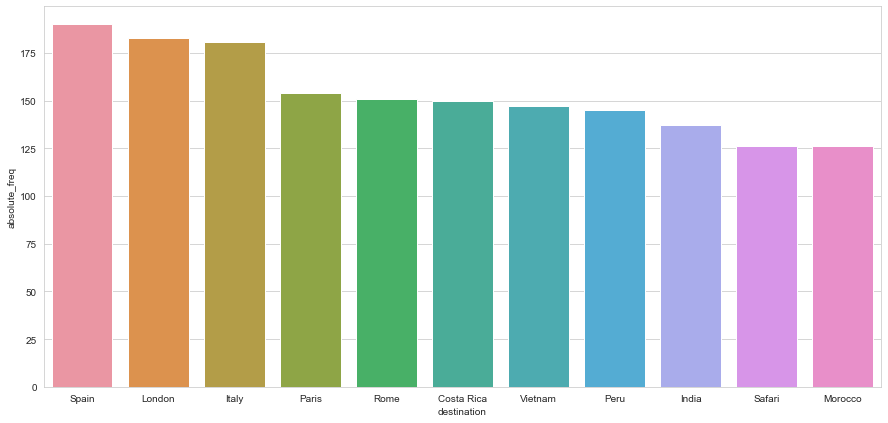

In [16]:
plot_top_destination()

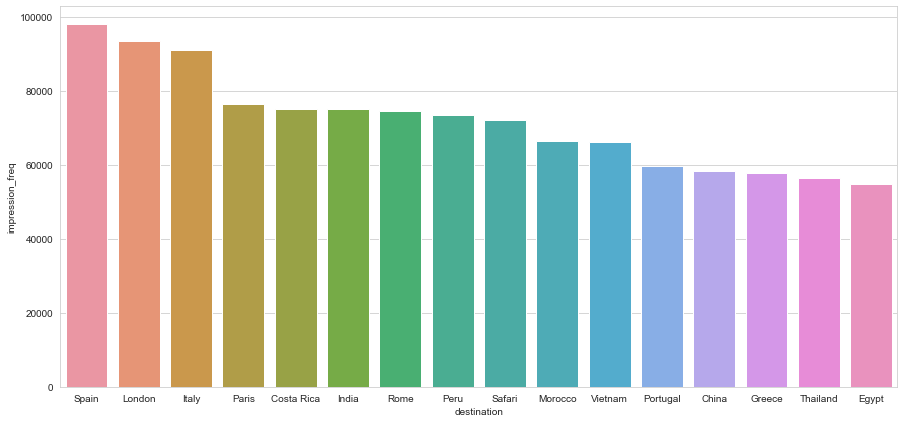

In [17]:
plot_top_destination('impression_freq',num_of_entires=15)

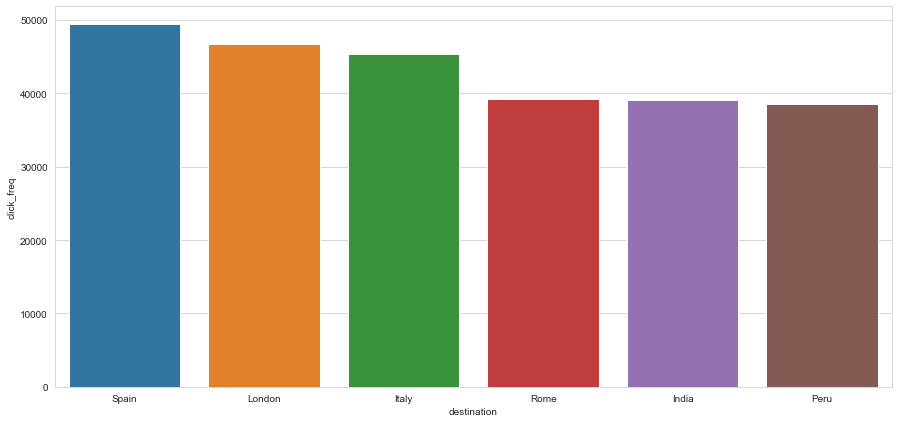

In [18]:
plot_top_destination('click_freq',5)

### Generating a list of words that would make for good keywords

Now that we have brainstormed the words that work well with the destinations we extracted, it is now time to combine them to generate meaningful search keywords.

In [19]:
words = ['best','private','independent','great','affordable','inclusive','active','scenic','romantic','local']
destinations = destination_freq.sort_values('absolute_freq',ascending=False).reset_index(drop=True).loc[:10,'destination'].to_list()

### Combining the words with destinations

In [20]:
# Create an empty list
keywords_list = []
# Loop through destinations
for product in destinations:
    # Loop through words
    for word in words:
        # Append combinations
        keywords_list.append([product, product + ' ' + word +' ' + 'tour'])
        keywords_list.append([product, word + ' ' + product +' ' + 'tour'])
from pprint import pprint
pprint(keywords_list)        

[['Spain', 'Spain best tour'],
 ['Spain', 'best Spain tour'],
 ['Spain', 'Spain private tour'],
 ['Spain', 'private Spain tour'],
 ['Spain', 'Spain independent tour'],
 ['Spain', 'independent Spain tour'],
 ['Spain', 'Spain great tour'],
 ['Spain', 'great Spain tour'],
 ['Spain', 'Spain affordable tour'],
 ['Spain', 'affordable Spain tour'],
 ['Spain', 'Spain inclusive tour'],
 ['Spain', 'inclusive Spain tour'],
 ['Spain', 'Spain active tour'],
 ['Spain', 'active Spain tour'],
 ['Spain', 'Spain scenic tour'],
 ['Spain', 'scenic Spain tour'],
 ['Spain', 'Spain romantic tour'],
 ['Spain', 'romantic Spain tour'],
 ['Spain', 'Spain local tour'],
 ['Spain', 'local Spain tour'],
 ['London', 'London best tour'],
 ['London', 'best London tour'],
 ['London', 'London private tour'],
 ['London', 'private London tour'],
 ['London', 'London independent tour'],
 ['London', 'independent London tour'],
 ['London', 'London great tour'],
 ['London', 'great London tour'],
 ['London', 'London affordable t

### Converting the list into a DataFrame

Now we want to convert this list of lists into a DataFrame so we can easily manipulate it and manage the final output.

In [21]:
# Create a DataFrame from list
keywords_df = pd.DataFrame.from_records(keywords_list)

# Rename the columns of the DataFrame
keywords_df = keywords_df.rename(columns={0:'Ad Group',1:'Keyword'})

# Add a campaign column
keywords_df['Campaign'] = 'SEM_tours'

# Add a criterion type column
keywords_df['Criterion Type'] = 'Exact'

# Make a copy of the keywords DataFrame
keywords_phrase = keywords_df.copy()

# Change criterion type match to phrase
keywords_phrase['Criterion Type'] = 'Phrase'

# Append the DataFrames
keywords_df_final = keywords_df.append(keywords_phrase)

# Create table for ads
keywords_df_final['Headline 1'] = 'Looking for ' + keywords_df_final['Keyword'] +'?'
keywords_df_final['Headline 2'] = 'Check Out Our Offers'
keywords_df_final['Description'] = 'Find the best guided trips to '+ keywords_df_final['Ad Group']
temp_url = keywords_df_final['Ad Group'].str.lower().str.replace(' ','-')
keywords_df_final['URL'] = 'https://www.stridetravel.com/'+ temp_url
keywords_df_final.head()

,Ad Group,Keyword,Campaign,Criterion Type,Headline 1,Headline 2,Description,URL
0,Spain,Spain best tour,SEM_tours,Exact,Looking for Spain best tour?,Check Out Our Offers,Find the best guided trips to Spain,https://www.stridetravel.com/spain
1,Spain,best Spain tour,SEM_tours,Exact,Looking for best Spain tour?,Check Out Our Offers,Find the best guided trips to Spain,https://www.stridetravel.com/spain
2,Spain,Spain private tour,SEM_tours,Exact,Looking for Spain private tour?,Check Out Our Offers,Find the best guided trips to Spain,https://www.stridetravel.com/spain
3,Spain,private Spain tour,SEM_tours,Exact,Looking for private Spain tour?,Check Out Our Offers,Find the best guided trips to Spain,https://www.stridetravel.com/spain
4,Spain,Spain independent tour,SEM_tours,Exact,Looking for Spain independent tour?,Check Out Our Offers,Find the best guided trips to Spain,https://www.stridetravel.com/spain


In [22]:
keywords_df_final.shape

(440, 8)